In [3]:
!unzip 'garbage.zip'

unzip:  cannot find or open garbage.zip, garbage.zip.zip or garbage.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: 'TrashType_Image_Dataset/cardboard'

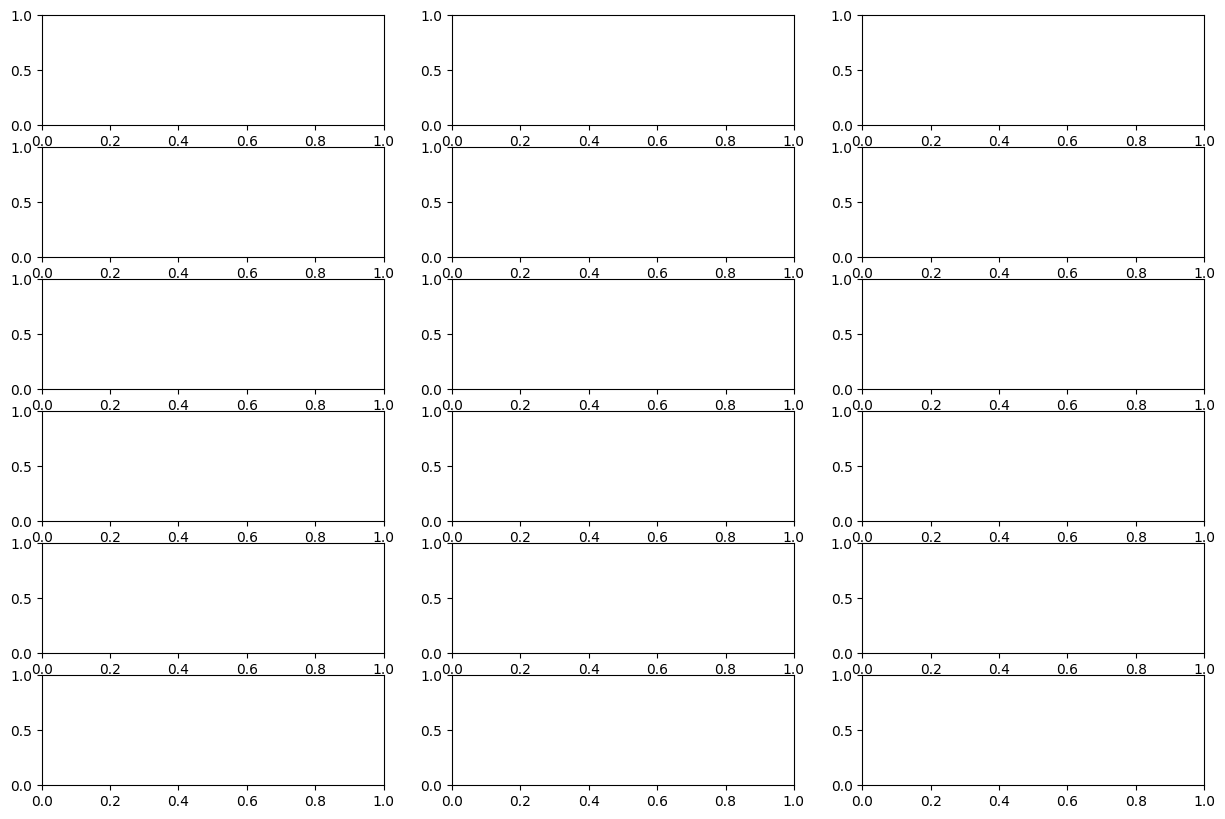

In [4]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path to the dataset
dataset_path = "TrashType_Image_Dataset"

# Define the categories
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Define the number of images to display from each category
num_images_to_display = 3

# Set up the plot
fig, axes = plt.subplots(len(categories), num_images_to_display, figsize=(15, 10))

# Loop through each category
for i, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)
    random.shuffle(image_files)  # Shuffle the list of image files

    # Display randomly selected images
    for j in range(num_images_to_display):
        img_file = image_files[j]
        img_path = os.path.join(category_path, img_file)
        img = mpimg.imread(img_path)
        axes[i, j].imshow(img)
        axes[i, j].set_title(category)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
import shutil

# Define the path to the dataset
dataset_path = "TrashType_Image_Dataset"

# Define the categories
categories = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

# Define the ratio of images to be allocated for the test set
test_size = 0.2

# Create directories for the training and test sets
train_dir = "train_dataset"
test_dir = "test_dataset"

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Loop through each category
for category in categories:
    category_path = os.path.join(dataset_path, category)
    image_files = os.listdir(category_path)

    # Split the image files into training and test sets
    train_images, test_images = train_test_split(image_files, test_size=test_size, random_state=42)

    # Copy training images to the train dataset directory
    for img_file in train_images:
        src_path = os.path.join(category_path, img_file)
        dest_path = os.path.join(train_dir, img_file)
        shutil.copy(src_path, dest_path)

    # Copy test images to the test dataset directory
    for img_file in test_images:
        src_path = os.path.join(category_path, img_file)
        dest_path = os.path.join(test_dir, img_file)
        shutil.copy(src_path, dest_path)

print("Dataset split into training and test sets successfully.")

FileNotFoundError: [Errno 2] No such file or directory: 'TrashType_Image_Dataset/cardboard'

In [15]:
def sort_images_into_folders(dataset_dir):
    # Iterate through the images in the dataset directory
    for filename in os.listdir(dataset_dir):
        if os.path.isfile(os.path.join(dataset_dir, filename)):
            # Extract the class name from the filename (e.g., cardboard, metal, etc.)
            class_name = filename.split("_")[0]

            # Create the class folder if it doesn't exist
            class_folder = os.path.join(dataset_dir, class_name)
            if not os.path.exists(class_folder):
                os.makedirs(class_folder)

            # Move the image to the class folder
            src = os.path.join(dataset_dir, filename)
            dst = os.path.join(class_folder, filename)
            shutil.move(src, dst)

# Define the paths to the train and test dataset directories
train_dataset_dir = "train_dataset"
test_dataset_dir = "test_dataset"

# Sort images into class folders for the train dataset
print("Sorting train dataset images into class folders...")
sort_images_into_folders(train_dataset_dir)
print("Train dataset images sorted successfully.")

# Sort images into class folders for the test dataset
print("Sorting test dataset images into class folders...")
sort_images_into_folders(test_dataset_dir)
print("Test dataset images sorted successfully.")

Sorting train dataset images into class folders...
Train dataset images sorted successfully.
Sorting test dataset images into class folders...
Test dataset images sorted successfully.


In [18]:
def count_images_in_split(folder):
    print(f"Folder: {folder}")
    classes = []
    for root, dirs, files in os.walk(folder):
        for dir in dirs:
            classes.append(dir)
    print(f"Classes: {classes}")
    for class_name in classes:
        class_path = os.path.join(folder, class_name)
        num_images = len(os.listdir(class_path))
        print(f"Class: {class_name} - Number of Images: {num_images}")

# Verify the number of images in each split for each class
print("Training Set:")
count_images_in_split('train_dataset/')

print("\nTest Set:")
count_images_in_split('test_dataset/')

Training Set:
Folder: train_dataset/
Classes: ['cardboard']
Class: cardboard - Number of Images: 1825

Test Set:
Folder: test_dataset/
Classes: []


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths to the training and test datasets
train_dir = "train_dataset/"
test_dir = "test_dataset/"

# Define image dimensions
img_height = 512
img_width = 384
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test Data Generator (only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1825 images belonging to 1 classes.
Found 0 images belonging to 0 classes.


In [2]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the InceptionV3 model pretrained on ImageNet without the top layer
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Add new top layers for classification
x = base_model_inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions_inception = Dense(6, activation='softmax')(x)  # 6 output classes for your dataset

# Define the new model
model_inception = Model(inputs=base_model_inception.input, outputs=predictions_inception)

# Freeze the layers of the pretrained model
for layer in base_model_inception.layers:
    layer.trainable = False

# Compile the model
model_inception.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_inception = model_inception.fit(train_generator, epochs=50, validation_data=validation_generator)

2025-11-14 11:16:30.889199: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-11-14 11:16:30.889344: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-14 11:16:30.889349: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-14 11:16:30.889689: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-14 11:16:30.890098: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/inception_v3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)

In [ ]:
# Define paths to the test dataset directory
test_dir = "test_dataset/"

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model on the test data
test_loss, test_accuracy = model_inception.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Found 508 images belonging to 6 classes.
16/16 [==============================] - 5s 274ms/step - loss: 0.2949 - accuracy: 0.8937
Test loss: 0.29492098093032837
Test accuracy: 0.8937007784843445


In [ ]:
model_inception.save("garbage_classification_model_inception.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NameError: name 'history_inception' is not defined

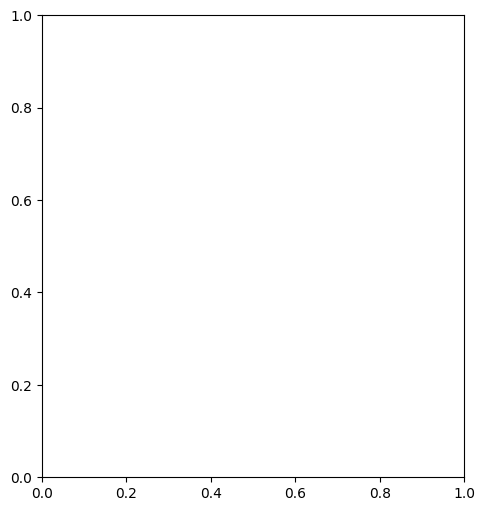

In [24]:
# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['loss'], label='Training Loss')
plt.plot(history_inception.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot training vs validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['accuracy'], label='Training Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing import image as keras_image

def predict_waste_category(image_path, model):
    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((384, 512))  # Resize the image to match the input shape of the model
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Predict the category of waste
    prediction = model.predict(img_array)
    waste_categories = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
    predicted_category_index = np.argmax(prediction)
    predicted_category = waste_categories[predicted_category_index]

    # Get the probability associated with the predicted category
    probability = prediction[0][predicted_category_index]
    return predicted_category, probability

# Example usage
image_path = "bottle.jpg"
predicted_category, probability = predict_waste_category(image_path, model_inception)
print("Predicted waste category:", predicted_category)

NameError: name 'model_inception' is not defined